In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import time
import jax.numpy as jnp
from jax import partial, jit, vmap, grad, random, lax
from jax.scipy.special import logsumexp

import context

from examples.bayesian_NN.NN_data import X_train, X_test, y_train, y_test
from examples.bayesian_NN.NN_model import grad_log_post, accuracy_BNN, get_ECE_MCE
from examples.bayesian_NN.sampler import sgld_NN, kernel_NN
from examples.bayesian_NN.util import flatten_NN_params, load_NN_MAP, flatten_NN_params_jaxscan
from examples.bayesian_NN.sampler import sgld_NN_time_budget, sgld_NN_time_budget_CV, scan_NN
from examples.bayesian_NN.adam_sgld import sgld_adam_NN_time_budget

from examples.bayesian_NN.NN_data import X_train_notMNIST, X_test_notMNIST, y_train_notMNIST, y_test_notMNIST
from examples.bayesian_NN.svrg import sgld_NN_time_budget_svrg

from ksd import imq_KSD
from util import progress_bar_scan, wait_until_computed

# plot KSD as a function of time budget

See end of notebook to reproduce the figures

In [7]:
def get_fb_grads_NN(samples):
    """
    Return full-batch gradients for NN samples
    samples list of NN sample. Each NN sample is a list of tuples
    """
    return [grad_log_post(sam, X_train, y_train) for sam in samples]

In [8]:
time_budget = 1

key = random.PRNGKey(0)
dt = 10**(-4.75)
batch_size = int(X_train.shape[0]*0.1)
params_IC = load_NN_MAP()

samples_NN_default, _ = sgld_NN_time_budget(key, time_budget, grad_log_post, dt, 
                                            batch_size, params_IC, X_train, y_train, save_rate=10)

print(len(samples_NN_default))

KeyboardInterrupt: 

## Define functions

1. Get gradients in batches
2. get KSD list for different time budgets

In [3]:
def get_KSD_list_time_budget_NN(max_time_budget, time_steps, sampler_fun, thin_step=2, start_time=5):
    "Get the KSD for a sampler run for each time budget up to `max_time_budget`"
    ksd_list = []
    for time_budget in np.arange(start_time, max_time_budget, time_steps):
        print(f"Running for time budget={time_budget}sec")
        samples = sampler_fun(time_budget)
        print(f"Num samples: {len(samples)}")
        fb_grads = get_fb_grads_NN(samples[::thin_step])
        
        flat_samples = flatten_NN_params(samples[::thin_step])
        flat_grads = flatten_NN_params(fb_grads)
        
        ksd_est = imq_KSD(flat_samples, flat_grads)
        ksd_list.append(ksd_est)
        print(f"KSD: {ksd_est:.1f}")
        print("\n")
    return ksd_list
    


# SGLD


#### R = 10sec with n=90

- Set `save_rate=10`


`key=0`:
- v1: -5.19, 0.011
- v2: -5.48, 0.0035
- v3: -5.62, 0.0027

`key=1`:
- v4: -5.31, 0.0033
- v5: -4.93, 0.023
- v6: -5.54, 0.002

`key=2`:
- v7: -5.48, 0.0050
- v8: -5.20, 0.035
- v9: -5.33, 0.0022

In [12]:
def run_many_KSD_curves_sgld(list_params):
    list_KSD_curves = []
    
    starttime = time.time()
    for log_dt, b_s_r in list_params:
        print(f"\nCalculating KSD curve for {log_dt, b_s_r}:")
        def run_sgld_sampler(time_budget):
            key = random.PRNGKey(0)
            MAP_params = load_NN_MAP()
            dt = 10**(log_dt)
            batch_size = int(b_s_r*X_train.shape[0])
            samples, _= sgld_NN_time_budget(key, time_budget, grad_log_post, dt, 
                                            batch_size, MAP_params, X_train, y_train, save_rate=10)
            return samples
        
        # ===
        max_time_budget =  20
        time_steps = 2
        thin_step = 2
        
        ksd_list_sgld_SH = get_KSD_list_time_budget_NN(max_time_budget, time_steps, 
                                                        run_sgld_sampler, thin_step=thin_step)
        list_KSD_curves.append(ksd_list_sgld_SH)
    print(f"Running time: {(time.time()-starttime)/60:.1f} min")
    return list_KSD_curves

In [18]:
# n=90
list_params_sgld_10 = [(-5.19, 0.011), (-5.48, 0.0035), (-5.62, 0.0027),
                       (-5.31, 0.0033), (-4.93, 0.023), (-5.54, 0.002),
                       (-5.48, 0.0050), (-5.20, 0.035), (-5.33, 0.0022)
                     ]


# list_KSD_curves_sgld_10 = run_many_KSD_curves_sgld(list_params_sgld_10)


Calculating KSD curve for (-5.19, 0.011):
Running for time budget=5sec
Num samples: 150
KSD: 291.7


Running for time budget=7sec
Num samples: 207
KSD: 253.6


Running for time budget=9sec
Num samples: 283
KSD: 228.6


Running for time budget=11sec
Num samples: 348
KSD: 208.1


Running for time budget=13sec
Num samples: 303
KSD: 221.0


Running for time budget=15sec
Num samples: 416
KSD: 194.7


Running for time budget=17sec
Num samples: 426
KSD: 192.5


Running for time budget=19sec
Num samples: 647
KSD: 156.5



Calculating KSD curve for (-5.48, 0.0035):
Running for time budget=5sec
Num samples: 307
KSD: 276.6


Running for time budget=7sec
Num samples: 394
KSD: 250.4


Running for time budget=9sec
Num samples: 570
KSD: 209.4


Running for time budget=11sec
Num samples: 801
KSD: 181.8


Running for time budget=13sec
Num samples: 966
KSD: 167.8


Running for time budget=15sec
Num samples: 1160
KSD: 155.0


Running for time budget=17sec
Num samples: 871
KSD: 176.2


Running for time b

### load/save KSD curves for SH - 10 sec

In [4]:
# n=90
# save all KSD curves
# for idx, elem in enumerate(list_KSD_curves_sgld_10):
#     np.savetxt(f"outputs/KSD_list/NN/sgld-SH_10-n_90/ksd_curve_{idx}.csv", elem)

# load all KSD curves
list_KSD_curves_sgld_10 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/NN/sgld-SH_10-n_90/ksd_curve_{idx}.csv")
    list_KSD_curves_sgld_10.append(mylist)

In [4]:
def sgld_sampler_default(time_budget):
    
    key = random.PRNGKey(0)
    MAP_params = load_NN_MAP()
    dt = 10**(-3.5)
    batch_size = int(0.1*X_train.shape[0])
    samples, _ = sgld_NN_time_budget(key, time_budget, grad_log_post, dt, 
                                batch_size, MAP_params, X_train, y_train, save_rate=10)
    return samples


# # ===
# max_time_budget = 20
# time_steps = 2
# thin_step = 2
# ksd_list_sgld_default = get_KSD_list_time_budget_NN(max_time_budget, time_steps, 
#                                                     sgld_sampler_default, thin_step=thin_step)



def sgld_sampler_adam(time_budget):
    key = random.PRNGKey(0)
    dt = 1e-4
    batch_size = int(0.1*X_train.shape[0])
    params_IC = load_NN_MAP()

    samples, _ = sgld_adam_NN_time_budget(key, time_budget, dt, batch_size, 
                                          X_train, y_train, params_IC, save_rate=10)
    return samples


# # ===
# max_time_budget = 20
# time_steps = 2
# thin_step = 1

# ksd_list_adam = get_KSD_list_time_budget_NN(max_time_budget, time_steps, sgld_sampler_adam, thin_step=thin_step)


### load/save KSD curves for adam and default samplers

In [36]:
# np.savetxt(f"outputs/KSD_list/NN/ksd_curve_adam.csv", ksd_list_adam)
# np.savetxt(f"outputs/KSD_list/NN/ksd_curve_sgld_default.csv", ksd_list_sgld_default)


ksd_list_adam = np.genfromtxt(f"outputs/KSD_list/NN/ksd_curve_adam.csv")
ksd_list_sgld_default = np.genfromtxt(f"outputs/KSD_list/NN/ksd_curve_sgld_default.csv")

### save KSD list arrays

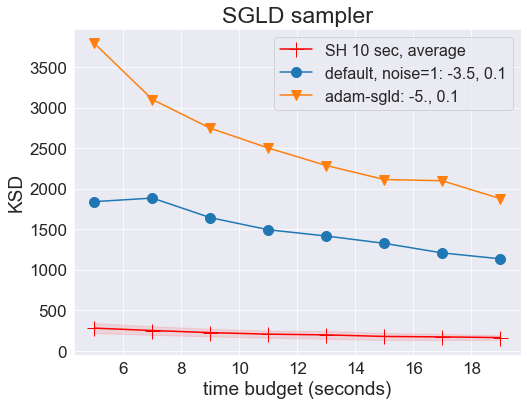

In [39]:
plt.rcParams.update({'font.size':17})

average_curve_sgld_SH10 = np.mean(list_KSD_curves_sgld_10, axis=0)
std_curve_sgld_SH10 = np.std(list_KSD_curves_sgld_10, axis=0)



max_time_budget = 20

plt.figure(figsize=(8, 6))

plt.plot(np.arange(5, max_time_budget, 2), average_curve_sgld_SH10, marker="+", markersize=15, 
         c='r', label="SH 10 sec, average")
plt.fill_between(np.arange(5, max_time_budget, 2), average_curve_sgld_SH10+2*std_curve_sgld_SH10, 
                 average_curve_sgld_SH10-2*std_curve_sgld_SH10, alpha=0.1, color='r')



# for elem in list_KSD_curves_sgld_10[:]:
#     plt.plot(np.arange(5, max_time_budget, 2), elem, alpha=0.4, marker="v")
    
plt.plot(np.arange(5, max_time_budget, 2), ksd_list_sgld_default, marker="o", 
         label="default, noise=1: -3.5, 0.1", markersize=10)

plt.plot(np.arange(5, max_time_budget, 2), ksd_list_adam, marker="v", 
         label="adam-sgld: -5., 0.1", markersize=10)


plt.title("SGLD sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/NN_sgld_ksd_curves.png") 

## uncertainty metrics: ECE and MCE

##### 1. sgld-SH

In [7]:
time_budget = 200

In [8]:
key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
# alternative: -5.48, 0.0050

dt = 10**(-5.19)
batch_size = int(0.011*X_train.shape[0])
samples_SH, _= sgld_NN_time_budget(key, time_budget, grad_log_post, dt, 
                                batch_size, MAP_params, X_train, y_train, save_rate=10)


print(f"Number of samples: {len(samples_SH)*10:,}")

Number of samples: 63,300


In [12]:
len(samples_SH)

6330

In [13]:
flat_samples_SH = flatten_NN_params(samples_SH)


0.014995448303222657 0.1635957


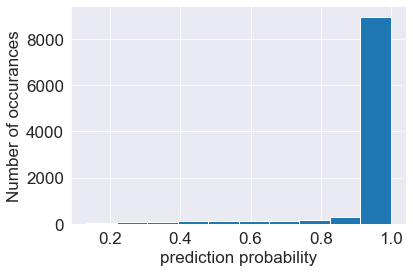

In [14]:


ece_NN_SH, mce_NN_SH = get_ECE_MCE(flat_samples_SH[::10], X_test, y_test, M=10)
print(ece_NN_SH, mce_NN_SH)



##### 2. default

In [16]:
key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(-3.5)
batch_size = int(0.1*X_train.shape[0])

samples_default, _ = sgld_NN_time_budget(key, time_budget, grad_log_post, dt, 
                            batch_size, MAP_params, X_train, y_train, save_rate=10)
print(len(samples_default))

In [17]:
flat_samples_default = flatten_NN_params(samples_default)


0.058884771728515625 0.29886198


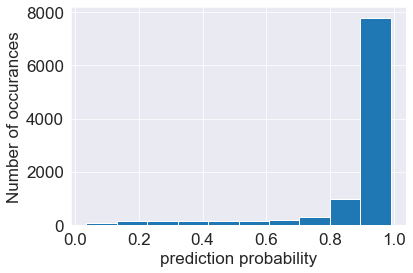

In [18]:


ece_NN_default, mce_NN_default = get_ECE_MCE(flat_samples_default[::10], X_test, y_test, M=10)
print(ece_NN_default, mce_NN_default)

#### 3. sgld-adam

In [20]:
time_budget = 200.

key = random.PRNGKey(0)
dt = 1e-5
batch_size = int(0.1*X_train.shape[0])
params_IC = load_NN_MAP()

samples_sgldadam, _ = sgld_adam_NN_time_budget(key, time_budget, dt, batch_size, 
                                      X_train, y_train, params_IC, save_rate=10)

print(f"Number of samples: {len(samples_sgldadam):,}")

Compiling
Running
Iteration 2000. Time: 34 / 200.0 sec
Iteration 4000. Time: 69 / 200.0 sec
Iteration 6000. Time: 104 / 200.0 sec
Iteration 8000. Time: 140 / 200.0 sec
Iteration 10000. Time: 177 / 200.0 sec
Number of samples: 1,125


In [21]:
flat_samples_adam = flatten_NN_params(samples_sgldadam)


0.01739776611328125 0.14612293


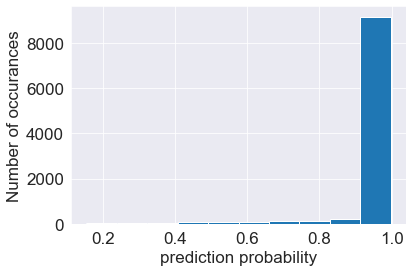

In [22]:
ece_NN_adam, mce_NN_adam = get_ECE_MCE(flat_samples_adam[::10], X_test, y_test, M=10)
print(ece_NN_adam, mce_NN_adam)



In [23]:
# key = 0 for all samplers
print("ECE: \n")
print(f"SH: {ece_NN_SH:.4f}")
print(f"default: {ece_NN_default:.4f}")
print(f"adam: {ece_NN_adam:.4f}")

print("\n===\nMCE: \n")
print(f"SH: {mce_NN_SH:.4f}")
print(f"default: {mce_NN_default:.4f}")
print(f"adam: {mce_NN_adam:.4f}")

ECE: 

SH: 0.0150
default: 0.0589
adam: 0.0174

===
MCE: 

SH: 0.1636
default: 0.2989
adam: 0.1461


# KSD curves: svrg

_Tune step size and batch size_

#### R = 15sec with n=90


`key=0`:
- v1: -5.19, 0.011
- v2: -4.84, 0.015
- v3: -4.80, 0.013

`key=1`:
- v4: -5.31, 0.0033
- v5: -4.93, 0.023
- v6: -4.89, 0.016

`key=2`:
- v7: -4.95, 0.0071
- v8: -5.33, 0.0022
- v9: -4.70, 0.028

 

In [7]:
def run_many_KSD_curves_svrg(list_params):
    list_KSD_curves = []
    
    starttime = time.time()
    for log_dt, b_s_r in list_params:
        print(f"\nCalculating KSD curve for {log_dt, b_s_r}:")
        def run_svrg_sampler(time_budget):
            key = random.PRNGKey(0)
            MAP_params = load_NN_MAP()
            dt = 10**(log_dt)
            update_rate = 1000
            batch_size = int(b_s_r*X_train.shape[0])
            samples = sgld_NN_time_budget_svrg(key, time_budget, dt, batch_size, 
                                           MAP_params, update_rate, save_rate=10)
            return samples
        
        # ===
        max_time_budget =  20
        time_steps = 2
        thin_step = 2
        
        
        ksd_list_sgld_SH = get_KSD_list_time_budget_NN(max_time_budget, time_steps, 
                                                        run_svrg_sampler, thin_step=thin_step)
        list_KSD_curves.append(ksd_list_sgld_SH)
    print(f"Running time: {(time.time()-starttime)/60:.1f} min")
    return list_KSD_curves

In [9]:
# n=120
list_params_svrg_10 = [(-5.19, 0.011), (-4.84, 0.015), (-4.80, 0.013),
                       (-5.31, 0.0033), (-4.93, 0.023), (-4.89, 0.016),
                       (-4.95, 0.0071), (-5.33, 0.0022), (-4.70, 0.028)
                      ]


list_KSD_curves_svrg_10 = run_many_KSD_curves_svrg(list_params_svrg_10)



Calculating KSD curve for (-5.19, 0.011):
Running for time budget=5sec
Num samples: 75
KSD: 340.2


Running for time budget=7sec
Num samples: 102
KSD: 310.6


Running for time budget=9sec
Num samples: 131
KSD: 267.0


Running for time budget=11sec
Num samples: 164
KSD: 231.0


Running for time budget=13sec
Num samples: 189
KSD: 214.3


Running for time budget=15sec
Num samples: 216
KSD: 196.5


Running for time budget=17sec
Num samples: 247
KSD: 181.9


Running for time budget=19sec
Num samples: 278
KSD: 171.1



Calculating KSD curve for (-4.84, 0.015):
Running for time budget=5sec
Num samples: 67
KSD: 430.1


Running for time budget=7sec
Num samples: 81
KSD: 393.9


Running for time budget=9sec
Num samples: 102
KSD: 348.3


Running for time budget=11sec
Num samples: 100
KSD: 354.1


Running for time budget=13sec
Num samples: 131
KSD: 302.0


Running for time budget=15sec
Num samples: 133
KSD: 298.2


Running for time budget=17sec
Num samples: 158
KSD: 272.5


Running for time budget

In [16]:
# n=120
# save all KSD curves
# for idx, elem in enumerate(list_KSD_curves_svrg_10):
#     np.savetxt(f"outputs/KSD_list/NN/svrg-SH_10-n_120/ksd_curve_{idx}.csv", elem)

# load all KSD curves
list_KSD_curves_svrg_10 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/NN/svrg-SH_10-n_120/ksd_curve_{idx}.csv")
    list_KSD_curves_svrg_10.append(mylist)
    
    

In [18]:
def svrg_sampler_default(time_budget):
    key = random.PRNGKey(0)
    MAP_params = load_NN_MAP()
    dt = 10**(-3.25)
    batch_size = int(0.1*X_train.shape[0])
    update_rate = 1000
    samples = sgld_NN_time_budget_svrg(key, time_budget, dt, batch_size, 
                                           MAP_params, update_rate, save_rate=10)
    return samples


# ===
max_time_budget = 20
time_steps = 2
thin_step = 2
# ksd_list_svrg_default = get_KSD_list_time_budget_NN(max_time_budget, time_steps, 
#                                                     svrg_sampler_default, thin_step=thin_step)



In [19]:
# np.savetxt(f"outputs/KSD_list/NN/ksd_curve_svrg_default.csv", ksd_list_svrg_default)

ksd_list_svrg_default = np.genfromtxt(f"outputs/KSD_list/NN/ksd_curve_svrg_default.csv")


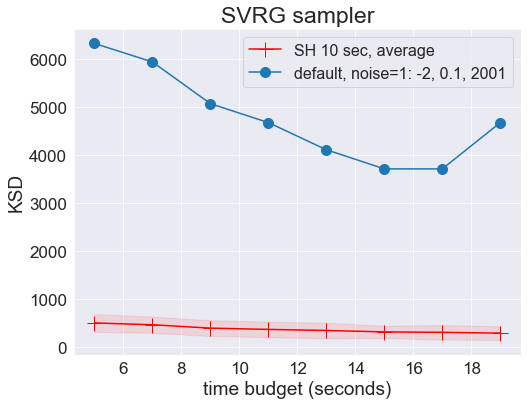

In [23]:
plt.rcParams.update({'font.size':17})

average_curve_svrg_SH10 = np.mean(list_KSD_curves_svrg_10, axis=0)
std_curve_svrg_SH10 = np.std(list_KSD_curves_svrg_10, axis=0)



max_time_budget = 20

plt.figure(figsize=(8, 6))

plt.plot(np.arange(5, max_time_budget, 2), average_curve_svrg_SH10, marker="+", markersize=15, 
         c='r', label="SH 10 sec, average")
plt.fill_between(np.arange(5, max_time_budget, 2), average_curve_svrg_SH10+2*std_curve_svrg_SH10, 
                 average_curve_svrg_SH10-2*std_curve_svrg_SH10, alpha=0.1, color='r')



# for elem in list_KSD_curves_svrg_10[:]:
#     plt.plot(np.arange(5, max_time_budget, 2), elem, alpha=0.4, marker="v")
    
plt.plot(np.arange(5, max_time_budget, 2), ksd_list_svrg_default, marker="o", label="default, noise=1: -2, 0.1, 2001", markersize=10)


plt.title("SVRG sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/NN_svrg_ksd_curves.png") 

## ECE and MCE


#### SH

In [9]:
time_budget = 200

log_dt, b_s_r, update_rate = -5.12, 0.011, 3074

key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(log_dt)
batch_size = int(b_s_r*X_train.shape[0])
samples_svrg_SH = sgld_NN_time_budget_svrg(key, time_budget, dt, batch_size, 
                               MAP_params, update_rate, save_rate=10)

#### default

In [10]:
time_budget = 200

log_dt, b_s_r, update_rate = -4., 0.1, 2001

key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(log_dt)
batch_size = int(b_s_r*X_train.shape[0])
samples_svrg_default = sgld_NN_time_budget_svrg(key, time_budget, dt, batch_size, 
                               MAP_params, update_rate, save_rate=10)

#### calculate ECE

In [11]:
flat_samples_svrg_SH = flatten_NN_params(samples_svrg_SH)
flat_samples_svrg_default = flatten_NN_params(samples_svrg_default)


In [12]:
ece_NN_svrg_SH, mce_NN_svrg_SH = get_ECE_MCE(flat_samples_svrg_SH[::10], X_test, y_test, M=10)
print(ece_NN_svrg_SH, mce_NN_svrg_SH)




0.014479922485351562 0.19471467


In [13]:
ece_NN_svrg_default, mce_NN_svrg_default = get_ECE_MCE(flat_samples_svrg_default[::10], X_test, y_test, M=10)
print(ece_NN_svrg_default, mce_NN_svrg_default)




0.03303507690429688 0.27398396


In [14]:
# key = 0 for all samplers
print("ECE: \n")
print(f"SH: {ece_NN_svrg_SH:.4f}")
print(f"default: {ece_NN_svrg_default:.4f}")

print("\n===\nMCE: \n")
print(f"SH: {mce_NN_svrg_SH:.4f}")
print(f"default: {mce_NN_svrg_default:.4f}")


ECE: 

SH: 0.0145
default: 0.0330

===
MCE: 

SH: 0.1947
default: 0.2740


### OOD testing

In [15]:
from examples.bayesian_NN.NN_model import _ood_testing
from examples.bayesian_NN.NN_data import X_train_notMNIST, X_test_notMNIST, y_train_notMNIST, y_test_notMNIST

In [19]:
ood_samples_SH_KSD = _ood_testing(flat_samples_svrg_SH[::5], X_test_notMNIST[::5])

wait_until_computed(ood_samples_SH_KSD)

In [20]:
ood_samples_default = _ood_testing(flat_samples_svrg_default[::5], X_test_notMNIST[::5])

wait_until_computed(ood_samples_default)

In [21]:
sorted_ood_SH_KSD = sorted(ood_samples_SH_KSD)
sorted_ood_default = sorted(ood_samples_default)


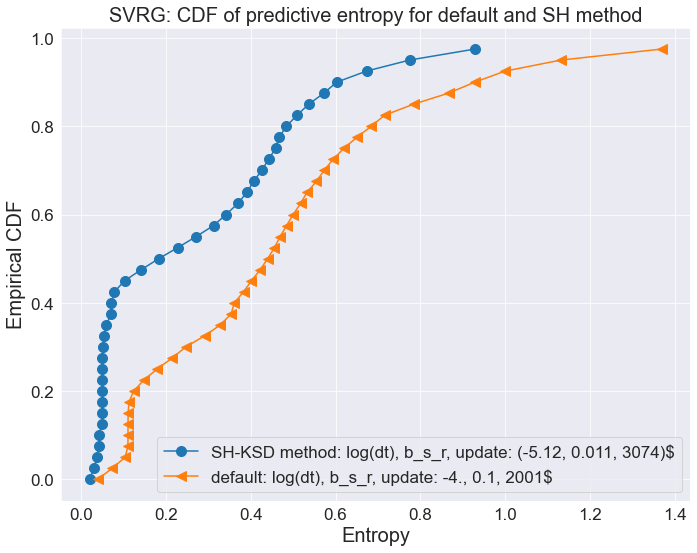

In [25]:
thin_step = 50

y_range = np.linspace(0, 1, (len(sorted_ood_SH_KSD)))[::thin_step]
plt.figure(figsize=(10,8))



plt.plot(sorted_ood_SH_KSD[::thin_step], y_range, 
         label=r"SH-KSD method: log(dt), b_s_r, update: (-5.12, 0.011, 3074)$", marker="o", markersize=10)


plt.plot(sorted_ood_default[::thin_step], y_range, 
         label=r"default: log(dt), b_s_r, update: -4., 0.1, 2001$", marker="<", markersize=10)


plt.title("SVRG: CDF of predictive entropy for default and SH method", size=20)
plt.tight_layout()
plt.legend()
plt.xlabel("Entropy", size=20)
plt.ylabel("Empirical CDF", size=20)
plt.tight_layout()
# plt.savefig("NN_notMSNIST_sgld_default_SH.png")

# sghmc

#### R = 30sec, with n=120, thin_step=5


`key=0`:
- v1: -5.59, 0.016, 3
- v2: -6.85, 0.0061, 9
- v3: -5.50, 0.053, 3

`key=1`:
- v4: -6.36, 0.012, 7
- v5: -6.92, 0.0066, 12
- v6: -6.45, 0.031, 8

`key=2`:
- v7: -5.88, 0.0066, 3
- v8: -6.99, 0.0043, 17
- v9: -6.75, 0.022, 6

 

In [4]:
from examples.bayesian_NN.sghmc import sghmc_NN_time_budget

In [5]:
time_budget = 3

key = random.PRNGKey(1)
dt = 1e-5
batch_size = int(X_train.shape[0]*0.05)
params = load_NN_MAP()
L = 10

samples = sghmc_NN_time_budget(key, time_budget, dt, batch_size, 
                                                 params, L, save_rate=10)

print(len(samples))

5


In [6]:
def run_many_KSD_curves_sghmc(list_params):
    list_KSD_curves = []
    
    starttime = time.time()
    for log_dt, b_s_r, L in list_params:
        print(f"\nCalculating KSD curve for {log_dt, b_s_r, L}:")
        def run_sghmc_sampler(time_budget):
            key = random.PRNGKey(0)
            MAP_params = load_NN_MAP()
            dt = 10**(log_dt)
            batch_size = int(b_s_r*X_train.shape[0])
            samples = sghmc_NN_time_budget(key, time_budget, dt, batch_size, 
                                                 MAP_params, L, save_rate=4)
            return samples
        
        # ===
        max_time_budget =  30
        time_steps = 2
        thin_step = 2
        
        ksd_list_sgld_SH = get_KSD_list_time_budget_NN(max_time_budget, time_steps, 
                                                        run_sghmc_sampler, thin_step=thin_step, start_time=15)
        list_KSD_curves.append(ksd_list_sgld_SH)
    print(f"Running time: {(time.time()-starttime)/60:.1f} min")
    return list_KSD_curves

In [8]:
# n=120
list_params_sghmc_30 = [(-5.59, 0.016, 3), (-6.85, 0.0061, 9), (-5.50, 0.053, 3),
                        (-6.36, 0.012, 7), (-6.92, 0.0066, 12), (-6.45, 0.031, 8),
                        (-5.88, 0.0066, 3), (-6.99, 0.0043, 17), (-6.75, 0.022, 6)
                       ]


# list_KSD_curves_sghmc_SH30 = run_many_KSD_curves_sghmc(list_params_sghmc_30)



Calculating KSD curve for (-5.59, 0.016, 3):
Running for time budget=15sec
Num samples: 430
KSD: 212.3


Running for time budget=17sec
Num samples: 467
KSD: 203.9


Running for time budget=19sec
Num samples: 527
KSD: 193.6


Running for time budget=21sec
Num samples: 378
KSD: 225.4


Running for time budget=23sec
Num samples: 586
KSD: 184.8


Running for time budget=25sec
Num samples: 666
KSD: 174.7


Running for time budget=27sec
Num samples: 599
KSD: 182.4


Running for time budget=29sec
Num samples: 698
KSD: 173.0



Calculating KSD curve for (-6.85, 0.0061, 9):
Running for time budget=15sec
Num samples: 267
KSD: 201.3


Running for time budget=17sec
Num samples: 293
KSD: 192.7


Running for time budget=19sec
Num samples: 275
KSD: 197.9


Running for time budget=21sec
Num samples: 329
KSD: 187.0


Running for time budget=23sec
Num samples: 323
KSD: 188.5


Running for time budget=25sec
Num samples: 310
KSD: 188.8


Running for time budget=27sec
Num samples: 374
KSD: 177.6


Running

In [8]:
# n=90
# save all KSD curves
# for idx, elem in enumerate(list_KSD_curves_sghmc_SH30):
#     np.savetxt(f"outputs/KSD_list/NN/sghmc-SH_30-n_120/ksd_curve_{idx}.csv", elem)

# load all KSD curves
list_KSD_curves_sghmc_SH30 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/NN/sghmc-SH_30-n_120/ksd_curve_{idx}.csv")
    list_KSD_curves_sghmc_SH30.append(mylist)

#### sghmc: default

In [15]:
def sghmc_sampler_default(time_budget):
    
    key = random.PRNGKey(0)
    MAP_params = load_NN_MAP()
    dt = 10**(-5)
    batch_size = int(0.1*X_train.shape[0])
    L = 26
    samples = sghmc_NN_time_budget(key, time_budget, dt, batch_size, 
                                         MAP_params, L, save_rate=4)
    return samples


# ===
max_time_budget = 30
time_steps = 2
thin_step = 2
# ksd_list_sghmc_default = get_KSD_list_time_budget_NN(max_time_budget, time_steps, 
#                                              sghmc_sampler_default, thin_step=thin_step, start_time=15)



Running for time budget=15sec
Num samples: 10
KSD: 9173.2


Running for time budget=17sec
Num samples: 11
KSD: 7663.3


Running for time budget=19sec
Num samples: 11
KSD: 7663.3


Running for time budget=21sec
Num samples: 13
KSD: 7012.5


Running for time budget=23sec
Num samples: 14
KSD: 7012.5


Running for time budget=25sec
Num samples: 15
KSD: 6167.2


Running for time budget=27sec
Num samples: 15
KSD: 6167.2


Running for time budget=29sec
Num samples: 17
KSD: 5604.6




In [9]:
# np.savetxt(f"outputs/KSD_list/NN/ksd_list_sghmc_default.csv", ksd_list_sghmc_default)

ksd_list_sghmc_default = np.genfromtxt(f"outputs/KSD_list/NN/ksd_list_sghmc_default.csv")


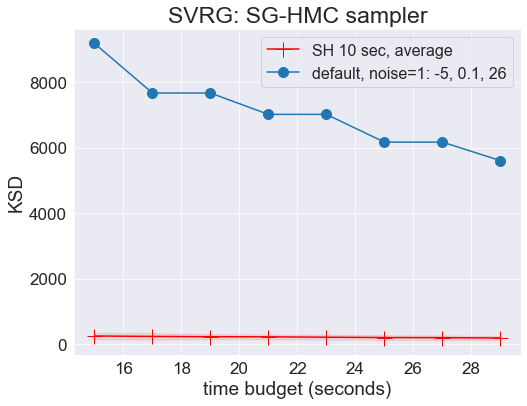

In [13]:
plt.rcParams.update({'font.size':17})

average_curve_sghmc_SH30 = np.nanmean(list_KSD_curves_sghmc_SH30, axis=0)
std_curve_sghmc_SH30 = np.nanstd(list_KSD_curves_sghmc_SH30, axis=0)



max_time_budget = 30

plt.figure(figsize=(8, 6))

plt.plot(np.arange(15, max_time_budget, 2), average_curve_sghmc_SH30, marker="+", markersize=15, 
         c='r', label="SH 10 sec, average")
plt.fill_between(np.arange(15, max_time_budget, 2), average_curve_sghmc_SH30+2*std_curve_sghmc_SH30, 
                 average_curve_sghmc_SH30-2*std_curve_sghmc_SH30, alpha=0.1, color='r')



# for elem in list_KSD_curves_sghmc_SH30[6:9]:
#     plt.plot(np.arange(15, max_time_budget, 2), elem, alpha=0.4, marker="v")
    
plt.plot(np.arange(15, max_time_budget, 2), ksd_list_sghmc_default, marker="o", 
                     label="default, noise=1: -5, 0.1, 26", markersize=10)


plt.title("SVRG: SG-HMC sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/PMF_sghmc_ksd_curves.png") 

## Test uncertainty

### SH

In [23]:
time_budget = 200

log_dt, b_s_r, L = -5.59, 0.016, 3

key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(log_dt)
batch_size = int(b_s_r*X_train.shape[0])
samples_sghmc_SH = sghmc_NN_time_budget(key, time_budget, dt, batch_size, 
                                         MAP_params, L, save_rate=10)

### default

In [24]:
time_budget = 200

log_dt, b_s_r, L = -5., 0.1, 26

key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(log_dt)
batch_size = int(b_s_r*X_train.shape[0])
samples_sghmc_default = sghmc_NN_time_budget(key, time_budget, dt, batch_size, 
                                         MAP_params, L, save_rate=10)

### ECE and MCE

In [25]:

flat_samples_sghmc_SH = flatten_NN_params(samples_sghmc_SH)
flat_samples_sghmc_default = flatten_NN_params(samples_sghmc_default)


In [26]:
ece_NN_sghmc_SH, mce_NN_sghmc_SH = get_ECE_MCE(flat_samples_sghmc_SH[::10], X_test, y_test, M=10)
print(ece_NN_sghmc_SH, mce_NN_sghmc_SH)




0.01177705841064453 0.15623441


In [27]:
ece_NN_sghmc_default, mce_NN_sghmc_default = get_ECE_MCE(flat_samples_sghmc_default[::10], X_test, y_test, M=10)
print(ece_NN_sghmc_default, mce_NN_sghmc_default)




0.21142587890625 0.5030676


In [28]:
# key = 0 for all samplers
print("ECE: \n")
print(f"SH: {ece_NN_sghmc_SH:.4f}")
print(f"default: {ece_NN_sghmc_default:.4f}")

print("\n===\nMCE: \n")
print(f"SH: {mce_NN_sghmc_SH:.4f}")
print(f"default: {mce_NN_sghmc_default:.4f}")


ECE: 

SH: 0.0118
default: 0.2114

===
MCE: 

SH: 0.1562
default: 0.5031


### OOD testing

In [29]:
from examples.bayesian_NN.NN_model import _ood_testing
from examples.bayesian_NN.NN_data import X_train_notMNIST, X_test_notMNIST, y_train_notMNIST, y_test_notMNIST


In [30]:
ood_samples_sghmc_SH_KSD = _ood_testing(flat_samples_sghmc_SH[::5], X_test_notMNIST[::5])

wait_until_computed(ood_samples_sghmc_SH_KSD)

In [31]:
ood_samples_sghmc_default = _ood_testing(flat_samples_sghmc_default[::5], X_test_notMNIST[::5])

wait_until_computed(ood_samples_sghmc_default)


In [32]:

sorted_ood_sghmc_SH_KSD = sorted(ood_samples_sghmc_SH_KSD)
sorted_ood_sghmc_default = sorted(ood_samples_sghmc_default)


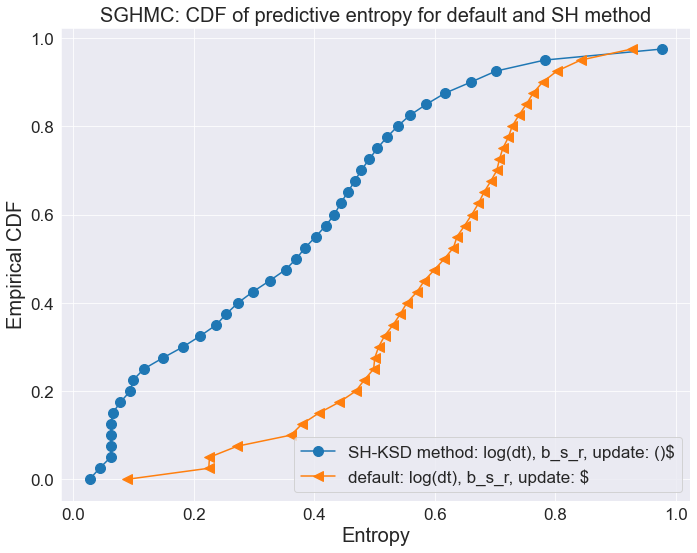

In [33]:
thin_step = 50

y_range = np.linspace(0, 1, (len(sorted_ood_sghmc_SH_KSD)))[::thin_step]
plt.figure(figsize=(10,8))



plt.plot(sorted_ood_sghmc_SH_KSD[::thin_step], y_range, 
         label=r"SH-KSD method: log(dt), b_s_r, update: ()$", marker="o", markersize=10)


plt.plot(sorted_ood_sghmc_default[::thin_step], y_range, 
         label=r"default: log(dt), b_s_r, update: $", marker="<", markersize=10)


plt.title("SGHMC: CDF of predictive entropy for default and SH method", size=20)
plt.tight_layout()
plt.legend()
plt.xlabel("Entropy", size=20)
plt.ylabel("Empirical CDF", size=20)
plt.tight_layout()
# plt.savefig("NN_notMSNIST_sgld_default_SH.png")

# 3 plots

In [4]:
# sgld

ksd_list_adam = np.genfromtxt(f"outputs/KSD_list/NN/ksd_curve_adam.csv")
ksd_list_sgld_default = np.genfromtxt(f"outputs/KSD_list/NN/ksd_curve_sgld_default.csv")
list_KSD_curves_sgld_10 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/NN/sgld-SH_10-n_90/ksd_curve_{idx}.csv")
    list_KSD_curves_sgld_10.append(mylist)
    
# svrg

ksd_list_svrg_default = np.genfromtxt(f"outputs/KSD_list/NN/ksd_curve_svrg_default.csv")
list_KSD_curves_svrg_10 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/NN/svrg-SH_10-n_120/ksd_curve_{idx}.csv")
    list_KSD_curves_svrg_10.append(mylist)
    
# sghmc 
list_KSD_curves_sghmc_SH30 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/NN/sghmc-SH_30-n_120/ksd_curve_{idx}.csv")
    list_KSD_curves_sghmc_SH30.append(mylist)

ksd_list_sghmc_default = np.genfromtxt(f"outputs/KSD_list/NN/ksd_list_sghmc_default.csv")


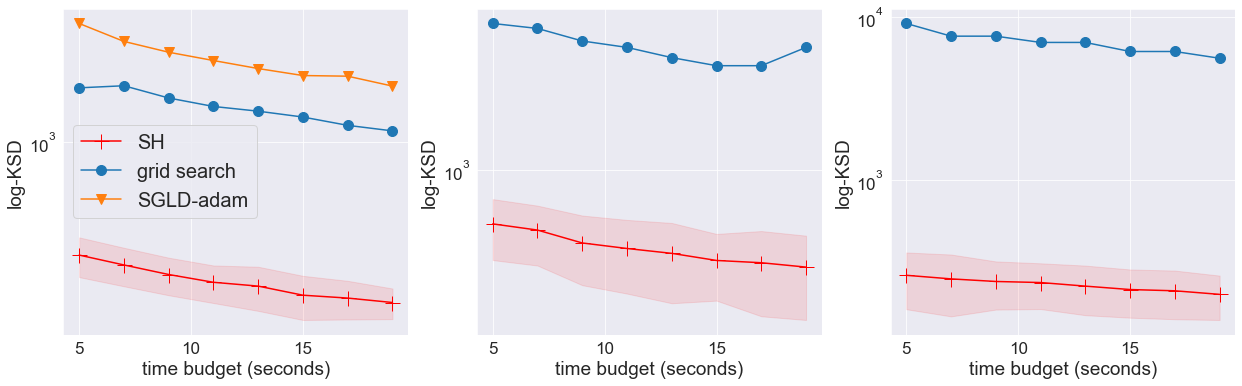

In [15]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(1,3, figsize=(21, 6), sharey=False)


# ===============
# SGLD
average_curve_sgld_SH10 = np.mean(list_KSD_curves_sgld_10, axis=0)
std_curve_sgld_SH10 = np.std(list_KSD_curves_sgld_10, axis=0)

max_time_budget_sgld = 20

ax[0].plot(np.arange(5, max_time_budget_sgld, 2), average_curve_sgld_SH10, marker="+", markersize=15, 
         c='r', label="SH")
ax[0].fill_between(np.arange(5, max_time_budget_sgld, 2), average_curve_sgld_SH10+2*std_curve_sgld_SH10, 
                 average_curve_sgld_SH10-2*std_curve_sgld_SH10, alpha=0.1, color='r')

ax[0].plot(np.arange(5, max_time_budget_sgld,2), ksd_list_sgld_default, marker="o", label="grid search", markersize=10)
ax[0].plot(np.arange(5, max_time_budget_sgld,2), ksd_list_adam, marker="v", label="SGLD-adam", markersize=10)


# ax[0].set_title("SGLD sampler", size=23)
ax[0].set_ylabel("log-KSD", size=19)
ax[0].set_xlabel("time budget (seconds)", size=19)
ax[0].legend(fontsize=20)



# ===============
# # SVRG

average_curve_sgldCV_SH10 = np.mean(list_KSD_curves_svrg_10, axis=0)
std_curve_sgldCV_SH10 = np.std(list_KSD_curves_svrg_10, axis=0)

max_time_budget_sgldCV = 20

ax[1].plot(np.arange(5, max_time_budget_sgldCV,2), average_curve_sgldCV_SH10, marker="+", markersize=15, 
         c='r', label="SH 5 sec, average")
ax[1].fill_between(np.arange(5, max_time_budget_sgldCV,2), average_curve_sgldCV_SH10+2*std_curve_sgldCV_SH10, 
                 average_curve_sgldCV_SH10-2*std_curve_sgldCV_SH10, alpha=0.1, color='r')

ax[1].plot(np.arange(5, max_time_budget_sgldCV, 2), ksd_list_svrg_default, marker="o", label="grid search", markersize=10)

# ax[1].set_title("SVRG sampler", size=23)
ax[1].set_ylabel("log-KSD", size=19)
ax[1].set_xlabel("time budget (seconds)", size=19)
# ax[1].legend(fontsize=20)


# ==================
# SG-HMC
average_curve_sghmc_SH10 = np.mean(list_KSD_curves_sghmc_SH30, axis=0)
std_curve_sghmc_SH10 = np.std(list_KSD_curves_sghmc_SH30, axis=0)

max_time_budget_sghmc = 20

ax[2].plot(np.arange(5, max_time_budget_sghmc,2), average_curve_sghmc_SH10, marker="+", markersize=15, 
         c='r', label="SH 10 sec, average")
ax[2].fill_between(np.arange(5, max_time_budget_sghmc,2), average_curve_sghmc_SH10+2*std_curve_sghmc_SH10, 
                 average_curve_sghmc_SH10-2*std_curve_sghmc_SH10, alpha=0.1, color='r')
    
ax[2].plot(np.arange(5, max_time_budget_sghmc,2), ksd_list_sghmc_default, marker="o", label="grid search", markersize=10)

# ax[2].set_title("SG-HMC sampler", size=23)
ax[2].set_ylabel("log-KSD", size=19)
ax[2].set_xlabel("time budget (seconds)", size=19)
# ax[2].legend(fontsize=20)
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
# plt.savefig("images/NN_KSD_curves.png")

